### Med-VLMs

In [1]:
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)

import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.model.builder import load_pretrained_model

/gpfs/users/restrepoda/.conda/envs/biomed-gpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2025-02-23 23:06:07,851] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
MODEL = "microsoft/llava-med-v1.5-mistral-7b"
model_name = get_model_name_from_path(MODEL)
model_name

'llava-med-v1.5-mistral-7b'

In [3]:
tokenizer, model, image_processor, context_len = load_pretrained_model(
                                                    model_path=MODEL, 
                                                    model_base=None, 
                                                    model_name=model_name, 
                                                    load_8bit=False)

/gpfs/users/restrepoda/.conda/envs/biomed-gpt/lib/python3.11/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using the legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This means that tokens that come after special tokens will not be properly handled. We recommend you to read the related pull request available at https://github.com/huggingface/transformers/pull/24565
You are using a model of type llava_mistral to instantiate a model of type llava. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards: 100%|██████████| 4/4 [00:43<00:00, 10.80s/it]
Some weights of LlavaLlamaForCausalLM were not initialized from the model checkpoint at microsoft/llava-med-v1.5-mistral-7b and are new

In [4]:
model.config._name_or_path.lower()

'microsoft/llava-med-v1.5-mistral-7b'

In [5]:
model.device

device(type='cuda', index=0)

In [6]:
def process_image(image):
    args = {"image_aspect_ratio": "pad"}

    image_tensor = process_images([image], image_processor, args)
    
    return image_tensor.to(model.device, dtype=torch.float16)

In [7]:
def apply_chat_template(conversation, add_generation_prompt=False):
    # The standard LLaVA approach is to do "conv.get_prompt()",
    # but you might want to replicate exactly what your code does.
    # This is the function that your "prompts.generate_text()" calls.
    ###roles = conversation[0].get("role", "user")
    # If you want the same approach as your "standard" llava, replicate
    # that logic here or see how you do it in your existing code.
    #
    # A simple approach is: build a single big string with <image> token
    # Then rely on the conversation's "conv_templates" from LLaVA.

    # For example, if you want to replicate the code in llava_med.py:
    #   conv = conv_templates["llava_v0"].copy()
    #   conv.append_message(conv.roles[0], conversation[0]["content"])
    #   conv.append_message(conv.roles[1], None)
    #   prompt = conv.get_prompt()
    #   return prompt
    # 
    # We'll do a minimal version below.

    
    # conversation[0]["content"] = [ {"type": "image"}, {"type": "text", "text": "..."} ]
    user_content_list = conversation[0]["content"]

    # Build a single string out of the list
    content_pieces = []
    for chunk in user_content_list:
        chunk_type = chunk.get("type", "text")
        if chunk_type == "image":
            # Insert the LLaVA default image token
            content_pieces.append(DEFAULT_IMAGE_TOKEN)
        elif chunk_type == "text":
            text_str = chunk.get("text", "")
            content_pieces.append(text_str)
        else:
            # If you have any other chunk types, handle them here
            content_pieces.append("")

    # Combine everything into one string, with a newline or space
    user_text = "\n".join(content_pieces)

    conv_mode = "llava_v0"
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], user_text)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    return prompt

In [8]:
conversation = [
    {
        "role": "user",
        # We assume your standard approach: <image> token + prompt
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Question"}
        ]
    }
]
ext_prompt = apply_chat_template(conversation, add_generation_prompt=True)
ext_prompt

"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>\nQuestion###Assistant:"

In [9]:
CONV_MODE = "llava_v0"

def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    #conv.system = conv.system = "A chat between a curious human and an artificial intelligence assistant. The assistant concrete and accurate answers to the human's questions."
    roles = conv.roles
    conv.append_message(roles[0], prompt)
    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [10]:
prompt, conv = create_prompt(DEFAULT_IMAGE_TOKEN + "\n" + "What type of imaging does this represent?")
print(prompt)
print("conv", conv)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
What type of imaging does this represent?###Assistant:
conv Conversation(system="A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.", roles=('Human', 'Assistant'), messages=[['Human', '<image>\nWhat type of imaging does this represent?'], ['Assistant', None]], offset=0, sep_style=<SeparatorStyle.SINGLE: 1>, sep='###', sep2=None, version='Unknown', skip_next=False)


In [11]:
from PIL import Image

def ask_image(image: Image, prompt: str):
    print("Input prompt:", prompt)
    image_tensor = process_image(image)

    #print(f"Image shape {image_tensor.shape}")
    
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )
    
    #print("Input IDs:", input_ids)


    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    #print("Stop", [stopping_criteria])

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=False,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
            output_attentions=True,
            output_scores=True,
            return_dict_in_generate=True
        )
    #return output_ids.keys()
        print(len(output_ids.sequences[0][input_ids.shape[1]:]))
        print("decoded output_ids", tokenizer.decode(output_ids.sequences[0][input_ids.shape[1]:])) #input_ids.shape[1] :
    return tokenizer.decode(
        output_ids.sequences[0][input_ids.shape[1] :], skip_special_tokens=True
    ).strip(), output_ids.scores, output_ids

In [12]:
#from src.datasets import load_mimic
#metadata_test = load_mimic(train=False, validation=False,check_images=False)

#metadata_test

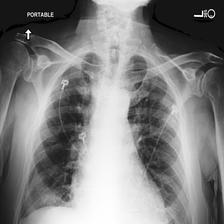

In [13]:
#img = Image.open(metadata_test.filepath[0])
img = Image.open('/gpfs/workdir/restrepoda/datasets/MIMIC/mimic/preproc_224x224/s53362948_bc351054-9432e570-d8e3300b-11abaaec-7641741f.jpg')
img

In [14]:
prompt = DEFAULT_IMAGE_TOKEN + "\n" + """ The AP radiograph of the chest demonstrates a top normal heart and
 mediastinum, stable in appearance.  As compared to the prior study, there is
 improvement in aeration of the lungs with minimal basal atelectasis but no
 evidence of consolidation to suggest development of infectious process.  No
 appreciable pleural effusion or pneumothorax is seen. Based on the provided patient information and the associated chest X-ray image, does the patien has any condition (Pleural Effusion, Atelectasis, Cardiomegaly, Consolidation, Edema, Enlarged Cardiomediastinum, Fracture, Lung Lesion, Lung Opacity, Pleural Other, Pneumonia, or Pneumothorax)?

Your response must be "Yes" if any condition is detected or "No" if no abnormality is detected. Your response should be only "yes" or "no" (without additional commentary)."""
out, logits, output_ids = ask_image(img, prompt)

Input prompt: <image>
 The AP radiograph of the chest demonstrates a top normal heart and
 mediastinum, stable in appearance.  As compared to the prior study, there is
 improvement in aeration of the lungs with minimal basal atelectasis but no
 evidence of consolidation to suggest development of infectious process.  No
 appreciable pleural effusion or pneumothorax is seen. Based on the provided patient information and the associated chest X-ray image, does the patien has any condition (Pleural Effusion, Atelectasis, Cardiomegaly, Consolidation, Edema, Enlarged Cardiomediastinum, Fracture, Lung Lesion, Lung Opacity, Pleural Other, Pneumonia, or Pneumothorax)?

Your response must be "Yes" if any condition is detected or "No" if no abnormality is detected. Your response should be only "yes" or "no" (without additional commentary).


/gpfs/users/restrepoda/.conda/envs/biomed-gpt/lib/python3.11/site-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


40
decoded output_ids  The chest X-ray image shows no appreciable pleural effusion or pneumothorax. Based on the provided information, the patient does not have any of the mentioned conditions. </s>


### Logits

In [15]:
import torch
torch.argmax(logits[0][0].softmax(dim=0))

tensor(415, device='cuda:0')

In [16]:
tokenizer.decode(415)

'The'

In [17]:
tokenizer.encode("yes") # [1, 5081]
logits[0][0][5081]

tensor(6.2656, device='cuda:0', dtype=torch.float16)

In [18]:
tokenizer.encode("no") # [1, 708]
logits[0][0][708]

tensor(7.8398, device='cuda:0', dtype=torch.float16)

In [19]:
tokenizer.encode("Yes") # [1, 5592]
logits[0][0][5592]

tensor(12.6641, device='cuda:0', dtype=torch.float16)

In [20]:
tokenizer.encode("No") # [1, 1770]
logits[0][0][1770]

tensor(12.5703, device='cuda:0', dtype=torch.float16)

### Attention

In [28]:
output_ids.attentions[0][0].shape

torch.Size([1, 32, 829, 829])